# Chapter 6: Fine-tuning for classifcation

#### Now we will fine-tune our LLM on a specific target task, such as classifying text.

<div style="max-width:600px">
    
![](images/6.0_1.png)

</div>

#### This figure highlights the two main ways of fine-tuning an LLM

## 6.1 Different categories of fine-tuning

#### Two most common ways to fine-tune language models 

1. #### Instruction fine-tuning
2. #### Classification fine-tuning

<div style="max-width:600px">
    
![](images/6.1_1.png)

</div>

#### Instruction fine-tuning involves training a language model on a set of tasks using specific instructions to improve its ability to understand and execute tasks described in natural language prompts, as illustrated above.

<div style="max-width:600px">
    
![](images/6.1_2.png)

</div>

#### In classification fine-tuning, the model is trained to recognize a specific set of class labels, such as "spam" and "not spam". Classification tasks can include things like identifying different species of plants from images, categorizing news articles into topics like sports, politics, and technology, and distinguishing between benign and malignant tumors in medical imaging. 

#### The key point is that a classification fine-tuned model is restricted to predicting classes it has encountered during its training. For example in the image above, the model can determine whether something is "spam" or "not spam", but cannot say anything else about the input.


#### Advantages and Disadvantages of each approach:

- #### classification fine-tuned models require less data and compute power, but its use is confined to the specific classes on which it has been trained
- #### classification fine-tuned models are easier to develop
- #### instruction fine-tuned models can undertake a broader range of tasks, but are harder to develop
- #### instruction fine-tuning requires a larger dataset and greater computational resources to develop models proficient in various tasks

## 6.2 Preparing the dataset

#### We will classification fine-tune the GPT model we previously implemented and pretrained. We begin by downloading a text message dataset that consists of spam and not spam messages.

<div style="max-width:600px">
    
![](images/6.2_1.png)

</div>

#### The three stage process for classfication fine-tuning:

1. #### Dataset preparation
2. #### Model setup
3. #### Model fine-tuning and evaluation

In [62]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_dataset(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction")
        return
        
    with urllib.request.urlopen(url) as response: # downloads the file
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref: # unzips file
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_dataset(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction


In [63]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


#### Lets examine the class label distribution

In [64]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


#### Because the data contains "ham" (not spam) far more than "spam", we will undersample the dataset to include 747 instances for each class

In [65]:
def create_balanced_dataset(df):
    num_spam = df[df["Label"] == "spam"].shape[0] # Counts instances of spam 
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123) # randomly samples "ham" instances to match number of spam instances
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]]) # combines ham subset with "spam"
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


#### Now we convert the string class labels to integers:
- #### "ham" -> 0
- #### "spam" -> 1

In [66]:
balanced_df["Label"] = balanced_df["Label"].map({"ham":0, "spam":1})

#### Now we create a random_split function to split our dataset into train, validation, and test portions

In [67]:
def random_split(df, train_frac, validation_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True) # shuffles entire dataframe

    # calculates split indices
    train_end = int(len(df) * train_frac)            
    validation_end = train_end + int(len(df) * validation_frac) 

    # splits df
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)

In [68]:
# save df's to CSV files to be used later
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

#### So far, we have downloaded the dataset, balanced it, and split it into training, validation, and testing subsets. Now we set up the PyTorch dataloaders that will be used to train the model.

## 6.3 Creating data loaders

#### Previously, we utilized a sliding window to generate uniformly sized text chunks, which were grouped into batches for more efficient model training. Each chunk functioned as an individual training instance. 

#### However, we are now working with a dataset that contains text messages of varying lengths. To batch these messages as we did with the text chunks, we have two options:

1. #### Truncate all messages to the shortest message in the dataset or batch
2. #### Pad all messages to the length of the longest message in the dataset or batch

#### The first option is computationally cheaper, but we can lose significant information if shorter messages are much smaller than average or longest messages, which can potentially reduce model performance. Therefore, we opt for the second option, which preserves the entire content of all messages.

#### We can add padding tokens to all shorter messsages until their length matches that of the longest message in the dataset. We can use "<|endoftext|>" as a padding token.

<div style="max-width:800px">
    
![](images/6.3_1.png)

</div>

#### However, instead of appending the string "<|endoftext|>" to each of the text messages directly, we can add the token ID corresponding to "<|endoftext|>" to the encoded messages, as shown in the figure above.

In [69]:
# Check to see what the encoding of <|endoftext|> is 

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


#### We need to implement a Pytorch dataset which specifies how the data is loaded and processed before we can instantiate the data loaders.

#### For this process, we instantiate the SpamDataset class which will implement the concept in the figure above. It handles several key tasks:

- #### identifies the longest sequence in the training dataset,
- #### encodes the text messages
- #### ensures that all other sequences are padded with a padding token to match the length of the longest sequence

In [70]:
import torch
from torch.utils.data import Dataset

In [71]:
class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)
        
        self.encoded_texts = [tokenizer.encode(text) for text in self.data["Text"]] # tokenizes the texts

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            self.encoded_texts = [encoded_text[:self.max_length] for encoded_text in self.encoded_texts] # truncates text sequence if longer than max_length

        self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) for encoded_text in self.encoded_texts] # adds padding

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (torch.tensor(encoded, dtype=torch.long), torch.tensor(label, dtype=torch.long))

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            max_length = max(max_length, len(encoded_text))
        return max_length

#### This class loads the data from csv, tokenizes the text messages, allows us to pad or truncate the sequences to a uniform length determined by either the longest sequence of maximum length parameter. 

#### This ensures each tensor is of the same size, which is necessary to create batches in the training data loader we implement next

In [72]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


#### The output 120 shows that the longest text message is only 120 tokens long. The model can handle sequences up to 1024 tokens, given its context_length limit. If the dataset included texts surpassing that length, you could pass 1024 as the max_length parameter when calling this function ensuring that the data does not exceed the models supported max input length

In [73]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

#### Using the datasets as inputs, we can instantiate the data loaders similarly to when we were working with text data. However, in this case the input is a text sequence and the target is a class label (rather than the next token in the text). 

#### For instance, if we choose a batch size of 8, each batch will consist of eight training examples of length 120 and the corresponding class label of each example

<div style="max-width:700px">
    
![](images/6.3_2.png)

</div>

In [74]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [75]:
# for input_batch, target_batch in train_loader:
#     pass
# print("Input batch dimensions:",input_batch.shape)
# print("Target batch dimensions:", target_batch.shape)

it = iter(train_loader)
inputs, label = next(it)

print("The first training sample out of the eight in the batch:\n",inputs[0, :])
print("\nShape of inputs in whole train batch:\n", inputs.shape)
print("\nThe first target label out of the eight in the batch:\n", label[0])
print("\nShape of target labels in whole train batch:\n", label.shape)

The first training sample out of the eight in the batch:
 tensor([   56,    64,   655,  5149,   450,    83,   294,    83,  4519,   492,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])

Shap

#### You can see the input batch consists of eight training examples with 120 tokens each, as expected. The label tensor stores the class labels corresponding to the eight training examples.

#### Lastly, to get an idea of the dataset size, lets print the total number of batches in each dataset.

In [76]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} testing batches")

130 training batches
19 validation batches
38 testing batches


## 6.4 Initializing a model with pretrained weights

#### We start the process of preparing the model for classification fine-tuning by initializing our pretrained model.

<div style="max-width:600px">
    
![](images/6.4_1.png)

</div>

In [77]:
BASE_CONFIG = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "drop_rate": 0.0,       # Dropout rate
    "qkv_bias": True        # Query-key-value bias
}

model_configs = {
    "gpt2-small-124M": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium-355M": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large-774M": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl-1558M": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-small-124M"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [78]:
import os
from previous_chapters import GPTModel, generate_text_simple, text_to_token_ids, token_ids_to_text

file_name = f"{CHOOSE_MODEL}.pth"
url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"Downloaded to {file_name}")


model = GPTModel(BASE_CONFIG)
model.load_state_dict(torch.load(file_name, weights_only=True))
model.eval()
model.to("cpu")
print("")

In [79]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


#### The output shows the model generates coherent text, which indicates that the model weights have been loaded correctly.

#### Before we start fine-tuning the model as a spam classifier, lets see whether the model already classifies spam messages by prompting it with instructions

In [80]:
text_2 = (
    "Is the following text 'spam'? Answer with a 'yes' or 'no':'You are a winner you have been specially selected to recieve $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with a 'yes' or 'no':'You are a winner you have been specially selected to recieve $1000 cash or a $2000 award.'

The following text 'spam'? Answer with a 'yes' or 'no':'You are a


#### Based on the output, it is clear the model is having trouble following instructions. This is expected, as it has only undergone pretraining and lacks instruction fine-tuning. Now, lets prepare the model for classification fine-tuning.

## 6.5 Adding a classification head

#### Now we must modify the pretrained LLM to prepare it for classification fine-tuning. To do this, we must replace the original output layer (that maps the last layer to a vocabulary of 50,257) to a smaller output layer that maps to two classes (0 and 1)

<div style="max-width:800px">
    
![](images/6.5_1.png)

</div>

In [81]:
def print_gpt_model_summary(model):
    print("GPTModel(")
    print(f"  (tok_emb): {model.tok_emb}")
    print(f"  (pos_emb): {model.pos_emb}")
    print(f"  (drop_emb): {model.drop_emb}")
    print(f"  (trf_blocks): Sequential(")
    print(f"    (0..11): TransformerBlock × 12")
    print("      (att): MultiHeadAttention(")
    print(f"        (W_query): {model.trf_blocks[0].att.W_query}")
    print(f"        (W_key): {model.trf_blocks[0].att.W_key}")
    print(f"        (W_value): {model.trf_blocks[0].att.W_value}")
    print(f"        (out_proj): {model.trf_blocks[0].att.out_proj}")
    print(f"        (dropout): {model.trf_blocks[0].att.dropout}")
    print("      )")
    print("      (ff): FeedForward(")
    print(f"        {model.trf_blocks[0].ff.layers}")
    print("      )")
    print(f"      (norm1): {model.trf_blocks[0].norm1}")
    print(f"      (norm2): {model.trf_blocks[0].norm2}")
    print(f"      (drop_resid): {model.trf_blocks[0].drop_resid}")
    print("  )")
    print(f"  (final_norm): {model.final_norm}")
    print(f"  (out_head): {model.out_head}")
    print(")")

print_gpt_model_summary(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0..11): TransformerBlock × 12
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        Sequential(
  (0): Linear(in_features=768, out_features=3072, bias=True)
  (1): GELU()
  (2): Linear(in_features=3072, out_features=768, bias=True)
)
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
  )
  (final_norm): LayerNorm()
  (out_head): Linear(in_features=768, out_features=50257, bias=False)
)


#### We want to replace "out_head" with a new output layer that we will fine-tune. 

#### To get the model ready for classification fine-tuning, we first freeze the model, meaning we make all layers nontrainable.

In [82]:
for param in model.parameters():
    param.requires_grad = False

<h4>
After freezing, we now replace the output layer (model.out_head) 
</h4>

In [83]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"],
    out_features=num_classes
)

#### This new output layer has the attribute requires_grad set to True by default, therefore, it will be the only layer in the model that will be updated during training.

#### Technically, this can be sufficient for fine-tuning, but including the last transformer block and the final LayerNorm in the fine-tuning process increases the performance of your model. 

In [84]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

#### Now lets test to see what the output of our model looks like now

In [85]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Input dimensions:", inputs.shape)

Inputs: tensor([[5211,  345,  423,  640]])
Input dimensions: torch.Size([1, 4])


In [86]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Output dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Output dimensions: torch.Size([1, 4, 2])


#### Previously, a similar input would have resulted in an output tensor with shape (1, 4, 50257), where 50257 represents the vocab size. 

#### The number of output rows corresponds to the number of tokens in the input (4). However, each output's embedding dimension (# of columns) is now 2 instead of 50257 because we replaced the output layer of the model.

#### Remember, we are interested in fine-tuning this model to return a class label indicating whether the input was "spam" or "not spam". We do not need to fine-tune all four output rows, rather we want to focus on the last row corresponding to the last output token.

In [87]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


#### Lets understand why we are only interested in the last output token. 

#### Remember that the attention mechanism creates a relationaship between each input token and every other input token. We also added a casual mask to our attention weights restricting a tokens focus to its current position and the ones before it. 

#### Therefore, the last output token in the sequence would accumulate the most information since it is the only token with access to data from all the previous tokens. That is why we focus on the last token during the fine-tuning process.

## 6.6 Calculating the classification loss and accuracy

#### Before we fine-tune the model we must implement the model evaluation functions used during fine-tuning

<div style="max-width:600px">
    
![](images/6.6_1.png)

</div>

#### Lets briefly cover how to convert our model outputs into class labels before implementing the evaluation utilities. We take the same approach as we did when we converted the 50,257 dimensional output tensors into tensors with probabilites via softmax, then returning the position with the highest probability using the argmax function. The only difference is instead we work with a 2-dimensional tensor instead. 


<div style="max-width:1000px">
    
![](images/6.6_2.png)

</div>


In [88]:
# Using softmax is optional because the largest outputs directly correspond to the highest probability scores.

logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


#### To determine the classfication accuracy (percentage of correct predictions across the dataset) we can apply the argmax-based prediction code to all examples in the dataset and calculate the proportion of correct predictions by defining this calc_accuracy_loader function

In [89]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(len(data_loader), num_batches)

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
                
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions/num_examples

#### Lets use this function to determine the classification accuracies across various datasets estimated from 10 batches for efficiency

In [90]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


#### Prediction accuracies are near random (50% since two classes) since we have not yet fine-tuned the model.

#### Before we fine-tune, we must define a loss function we will optimize during our training. The calc_loss_batch function remains the same, with the only adjustment being we focus on optimizing only the last token model(input_batch)[:, -1, :], rather than all tokens model(input_batch) 

In [91]:
# Calculate the loss for a single batch in a dataloader

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    logits = model(input_batch)[:, -1, :]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

# Calculates the loss for all batches in the dataloader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

#### Let's compute the initial loss for each data set

In [92]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


#### Now we can implement a training function to fine-tune the model (adjusting the model to minimize the training set loss).

## 6.7 Fine-tuning the model on supervised data

#### Now we will define and use the training function to fine-tune the pretrained LLM and improve its spam classificaion accuracy.

<div style="max-width:700px">
    
![](images/6.7_1.png)

</div>

#### The training loop, shown above, is the same overall training loop we used for pretraining, the only difference being that we calculate the classification accuracy instead of generating sample text to evaluate the model.

In [93]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [94]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 0.97 mi

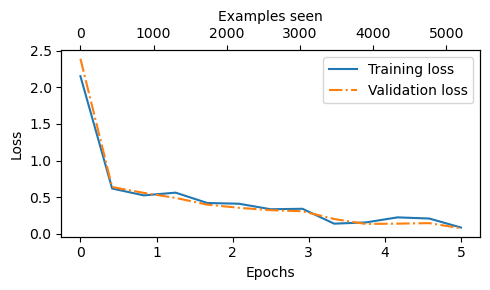

In [95]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))


    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()


    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

#### This is a graph of the models training over the five epochs. Both lines sharply decline in the first epoch and gradually stabalize toward the fifth epoch. This is a good indication of learning progress and suggests that the model learned from the training data while generalizing well to the unseen validation data.

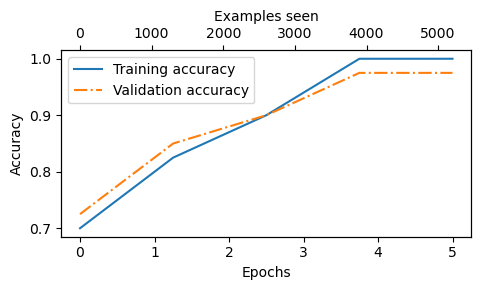

In [96]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

#### Both training and validation accuracy increase substantially in the early epochs, and plateau, achieving an almost perfect accuracy score. Notice how the two lines are close to eachother, this indicates that the model does not overfit the training data very much (since the validation accuracy, which is unseen data, is in close proximity to the training accuracy, meaning  the model is generalizing well to unseen examples).

#### Now lets calculate the accuracy scores of the model on the training, validation, and test sets across the entire dataset by not defining the eval_iter value

In [97]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


## 6.8 Using the LLM as a spam classifier

#### We have now fine-tuned and evaluated the model and are ready to classify spam messages.

<div style="max-width:700px">
    
![](images/6.8_1.png)

</div>

#### The following function will follow the data preprocessing steps similar to those we used in the SpamDataset implemented earlier, then after turning text into token IDs, it will use the model to predict an integer class label, and return the corresponding class name

In [98]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[-1]

    input_ids = input_ids[:min(max_length, supported_context_length)]
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]

    predicted_label = torch.argmax(logits, dim=-1).item()
    
    return "spam" if predicted_label==1 else "not spam"

In [99]:
text_1 = "You are a winner you have been specially selected to recieve $1000 cash or a $2000 award."
print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [100]:
text_2 = "Hey, just wanted to check if we're still on for dinner tonight? Let me know!"
print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [101]:
torch.save(model.state_dict(), "review_classifier.pt")